In [1]:
import nibabel as nib
import numpy as np
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

In [ ]:
def plot_intensity_histogram(original, noisy, bins=100, title="Intensity Histogram"):
    """
    Plot histograms of voxel intensities before and after noise addition.

    Parameters:
    - original: ndarray
        The original 3D medical image (voxel intensities).
    - noisy: ndarray
        The same 3D image after noise has been added.
    - bins: int, optional (default=100)
        Number of histogram bins to divide intensity values.
    - title: str, optional
        Title of the histogram plot.
    """
    # Create a new figure with defined size (10 inches wide, 5 inches tall)
    plt.figure(figsize=(10, 5))

    # Plot histogram of original voxel intensities
    # - Flatten converts 3D image to 1D array
    # - alpha controls transparency (0.5 = 50% see-through)
    # - density=True normalizes histogram so area under curve = 1
    plt.hist(original.flatten(), bins=bins, alpha=0.5, label='Original', density=True)

    # Plot histogram of noisy voxel intensities (same settings for comparison)
    plt.hist(noisy.flatten(), bins=bins, alpha=0.5, label='Noisy', density=True)

    # Add title to the plot
    plt.title(title)

    # Label the x-axis (intensity values) and y-axis (probability density)
    plt.xlabel('Intensity')
    plt.ylabel('Density')

    # Add legend to distinguish between original and noisy histograms
    plt.legend()

    # Add grid lines for easier visualization
    plt.grid(True)

    # Display the plot
    plt.show()

In [ ]:
def visualize_single_slice(
    original_image,
    transformed_image,
    slice_index,
    title_prefix="Transformed",
    com_before=None,
    com_after=None
):
    """
    Display a side-by-side visualization of a single slice from original and transformed 3D images.

    Parameters:
    - original_image: 3D NumPy array
        The original medical image volume (shape: H x W x D).
    - transformed_image: 3D NumPy array
        The transformed/processed version of the original image (same shape).
    - slice_index: int
        Index of the axial slice (along the last axis) to display.
    - title_prefix: str, optional (default="Transformed")
        Title prefix for the transformed image subplot.
    - com_before: tuple or None
        Center of mass (x, y, z) of the original image (optional, for annotation).
    - com_after: tuple or None
        Center of mass (x, y, z) of the transformed image (optional, for annotation).
    """
    # Create a figure with two side-by-side subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Add an overall title for the figure showing which slice is being visualized
    fig.suptitle(f"Slice {slice_index} - {title_prefix}", fontsize=14)

    # --- Left subplot: Original image ---
    # Display the selected slice from the original image (grayscale colormap)
    axes[0].imshow(original_image[:, :, slice_index], cmap='gray')

    # Build the title string for the original image subplot
    title_left = 'Original'
    if com_before:  # If a center of mass is provided, append it
        title_left += f"\nCOM: {np.round(com_before, 2)}"
    axes[0].set_title(title_left)

    # Remove axis ticks and labels for cleaner visualization
    axes[0].axis('off')

    # --- Right subplot: Transformed image ---
    # Display the same slice from the transformed image
    axes[1].imshow(transformed_image[:, :, slice_index], cmap='gray')

    # Build the title string for the transformed image subplot
    title_right = f"{title_prefix}"
    if com_after:  # If a transformed center of mass is provided, append it
        title_right += f"\nCOM: {np.round(com_after, 2)}"
    axes[1].set_title(title_right)

    # Remove axis ticks and labels
    axes[1].axis('off')

    # Adjust layout to prevent overlapping titles/labels
    plt.tight_layout()

    # Display the figure
    plt.show()

In [ ]:
def rotate_3d_image(image_path, angle):
    """
    Rotate a 3D medical image slice-by-slice around the axial plane (z-axis).

    Parameters:
    - image_path: str
        Path to the NIfTI (.nii or .nii.gz) file.
    - angle: float
        Rotation angle in degrees (counter-clockwise).

    Returns:
    - image_data: np.ndarray
        Original 3D image data as a NumPy array.
    - rotated_image: np.ndarray
        Rotated 3D image data with the same shape as the original.
    """
    # Load the NIfTI image using nibabel
    img_nifti = nib.load(image_path)

    # Extract image data as a NumPy array (H x W x D)
    image_data = img_nifti.get_fdata()

    # Create an empty array of the same shape to store rotated slices
    rotated_image = np.zeros_like(image_data)

    # Loop through each axial slice (z-axis slices)
    for i in range(image_data.shape[2]):
        # Rotate the 2D slice in-plane
        # - reshape=False keeps the same shape
        # - order=1 uses bilinear interpolation
        # - mode='nearest' fills outside pixels with nearest value
        # - np.rint rounds results to nearest integer (useful if input is discrete labels)
        rotated_image[:, :, i] = np.rint(
            rotate(image_data[:, :, i], angle, reshape=False, order=1, mode='nearest')
        )

    return image_data, rotated_image

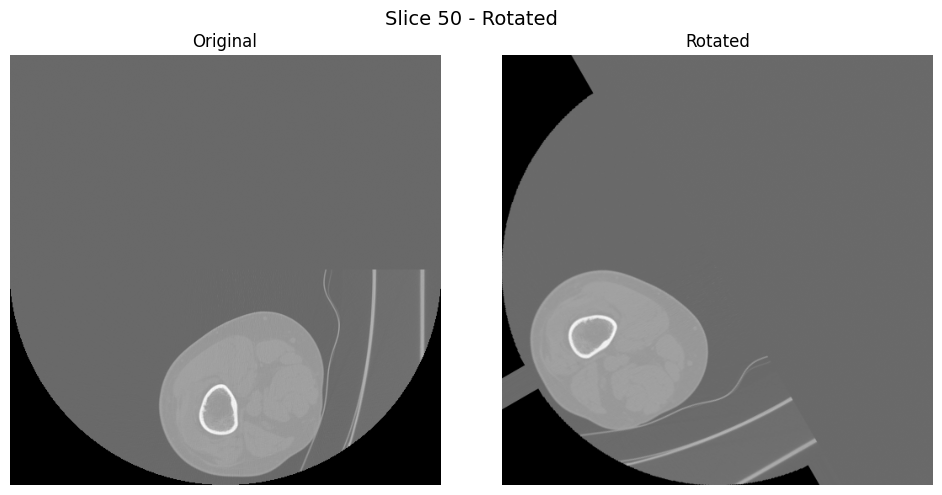

In [ ]:
# Rotate the 3D image by -60 degrees (clockwise)
# - Returns original and rotated 3D NumPy arrays
original_img, rotated_img = rotate_3d_image(
    image_path=r"/home/anuuu/Documents/Internship/Tasks/Perturbation/left_bilateral_knee_1_image.nii.gz",
    angle=-60
)

# Visualize a specific slice (slice index 50) from both volumes
# - Left: Original image slice
# - Right: Rotated image slice
# - Title shows "Rotated" as a prefix
visualize_single_slice(
    original_img,
    rotated_img,
    slice_index=50,
    title_prefix="Rotated"
)

In [13]:
from scipy.ndimage import shift, center_of_mass
import nibabel as nib
import numpy as np

def translate_image(image_path, voxel_shift_fraction=(0.25, 0, 0)):
    # Load image
    img_nifti = nib.load(image_path)
    image_data = img_nifti.get_fdata()
    spacing = img_nifti.header.get_zooms()  # voxel spacing (dx, dy, dz)

    # Convert physical shift (in mm) to voxel shift
    voxel_shift = tuple(f / s for f, s in zip(voxel_shift_fraction, spacing))

    # Measure center of mass before
    com_before = center_of_mass(image_data)

    # Apply translation
    translated_image = shift(image_data, shift=voxel_shift, order=1, mode='nearest')

    # Measure center of mass after
    com_after = center_of_mass(translated_image)

    return image_data, translated_image, com_before, com_after


In [ ]:
img_path = r'/home/anuuu/Documents/Internship/Tasks/Perturbation/left_bilateral_knee_1_image.nii.gz'

original_img, translated_img, com_before, com_after = translate_image(
    image_path=img_path,
    voxel_shift_fraction=(51.25, 51.25, 51.25)  # in all directions
)



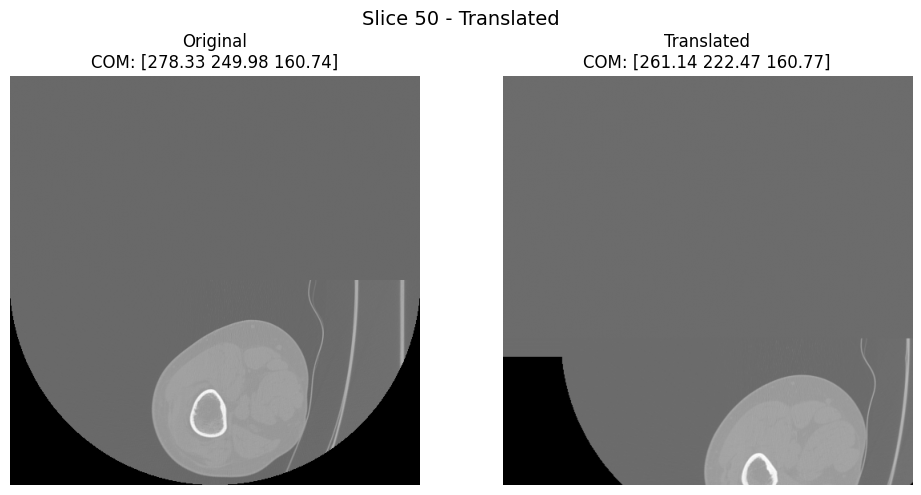

In [19]:
visualize_single_slice(original_img, translated_img, slice_index=50, title_prefix="Translated", com_before=com_before, com_after=com_after)


In [25]:
import numpy as np

import nibabel as nib


def add_speckle_noise(image_path, std=0.1):
    """
    Adds speckle noise to a 3D image volume loaded from a NIfTI file.

    Parameters:
    - image_path: Path to the NIfTI file
    - std: Standard deviation of speckle noise (0.05–0.2 typical)

    Returns:
    - original_image: the original 3D image volume (NumPy array)
    - noisy_image: 3D image volume with speckle noise added
    """
    # Load image
    img_nifti = nib.load(image_path)
    image = img_nifti.get_fdata()

    # Apply speckle noise
    noise = np.random.normal(loc=0, scale=std, size=image.shape)
    noisy_image = image + image * noise

    return image, noisy_image



In [ ]:
def estimate_noise(original, noisy):
    """
    Estimate standard deviation of noise added.

    Returns estimated noise volume and standard deviation.
    """
    estimated_noise = noisy - original
    estimated_std = np.std(estimated_noise)
    return estimated_noise, estimated_std




Estimated noise std: 396.926


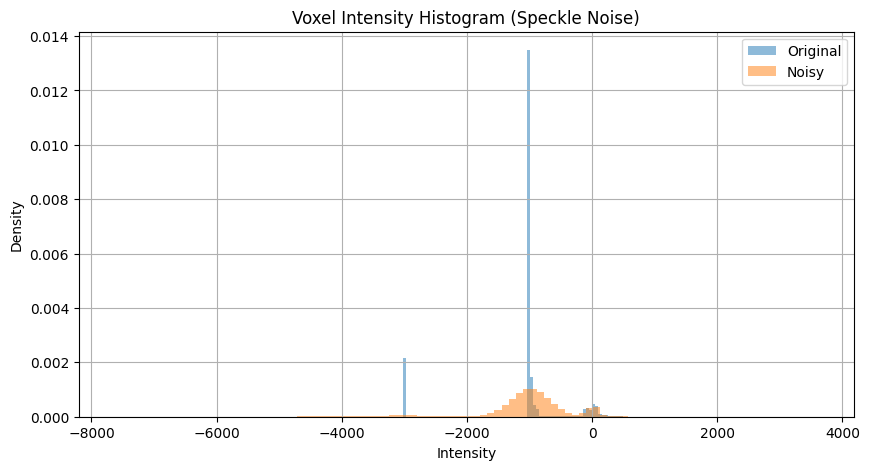

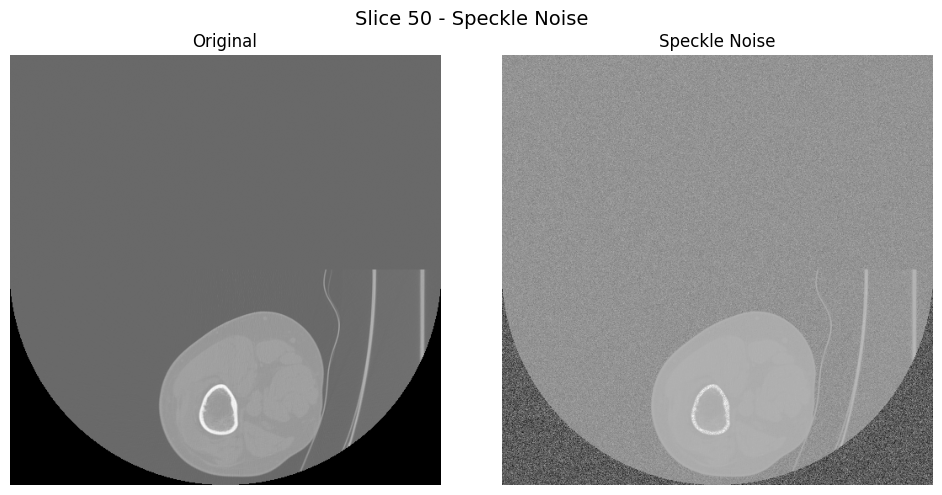

In [ ]:

# Add speckle noise
original_image, noisy_image = add_speckle_noise(img_path, std=0.3)

# Estimate noise
noise_volume, noise_std = estimate_noise(original_image, noisy_image)
print(f"Estimated noise : {noise_volume:.3f}")
print(f"Estimated noise std: {noise_std:.3f}")

# Plot histograms
plot_intensity_histogram(original_image, noisy_image, title="Voxel Intensity Histogram (Speckle Noise)")

# Visualize slice
visualize_single_slice(original_image, noisy_image, slice_index=50, title_prefix="Speckle Noise")


In [34]:
import nibabel as nib
import numpy as np

def add_poisson_noise(image_path, scale_factor=1e3):
    """
    Add Poisson noise to simulate low-dose CT.

    Parameters:
    - image_path: path to NIfTI file
    - scale_factor: scaling to convert image to pseudo-photon counts

    Returns:
    - original_image: original 3D image
    - noisy_image: image with Poisson noise
    """
    # Load image
    img_nifti = nib.load(image_path)
    image = img_nifti.get_fdata()

    # Normalize to non-negative range if needed
    image = image - np.min(image)
    
    # Scale to pseudo photon count domain
    scaled = image * scale_factor

    # Apply Poisson noise
    noisy_scaled = np.random.poisson(scaled)

    # Rescale back to original intensity range
    noisy_image = noisy_scaled / scale_factor

    return image, noisy_image


Estimated noise std: 138.920


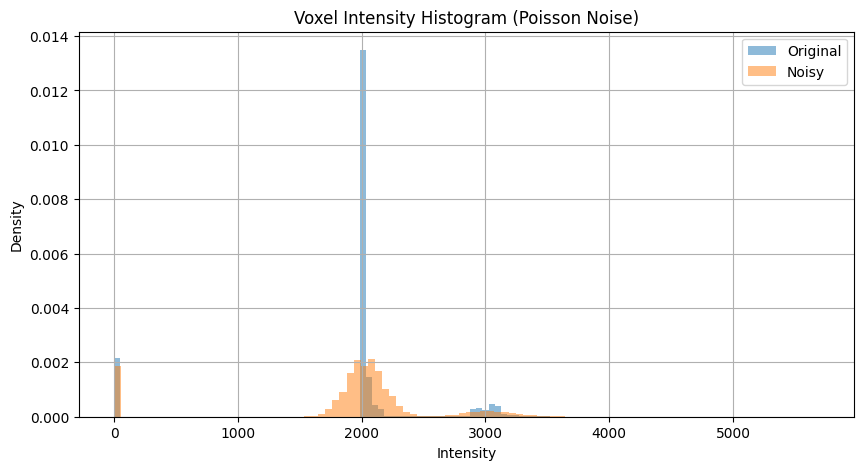

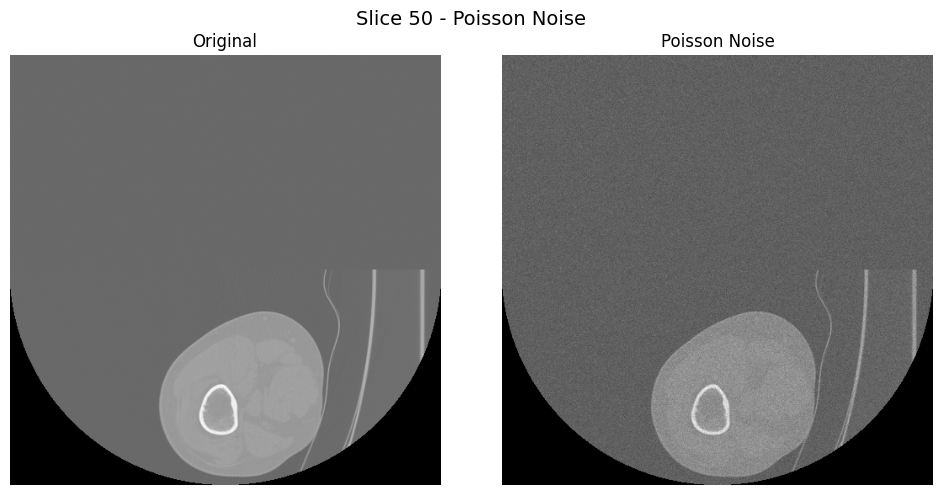

In [ ]:
img_path = r'/home/anuuu/Documents/Internship/Tasks/Perturbation/left_bilateral_knee_1_image.nii.gz'

# Apply Poisson noise
original_image, poisson_noisy_image = add_poisson_noise(img_path, scale_factor=0.1)

# Estimate noise
noise_volume, noise_std = estimate_noise(original_image, poisson_noisy_image)
print(f"Estimated noise std: {noise_std:.3f}")

# Plot histogram
plot_intensity_histogram(original_image, poisson_noisy_image, title="Voxel Intensity Histogram (Poisson Noise)")

# Visualize slice
visualize_single_slice(original_image, poisson_noisy_image, slice_index=50, title_prefix="Poisson Noise")


Erased region std (rough): 409.431


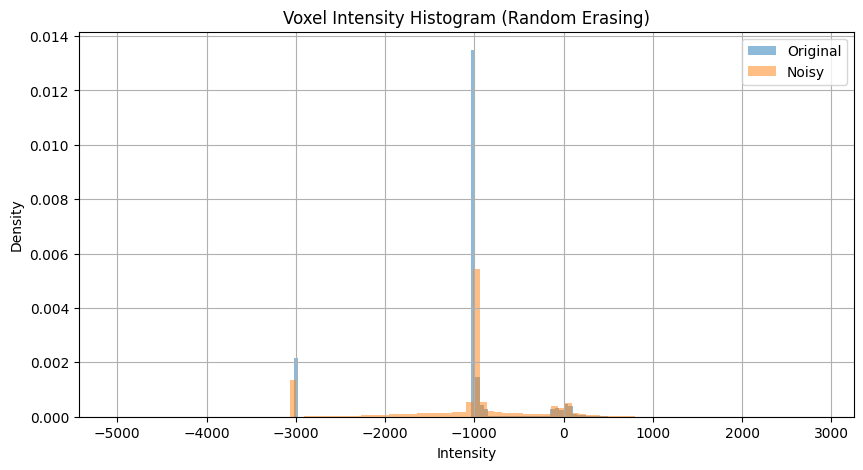

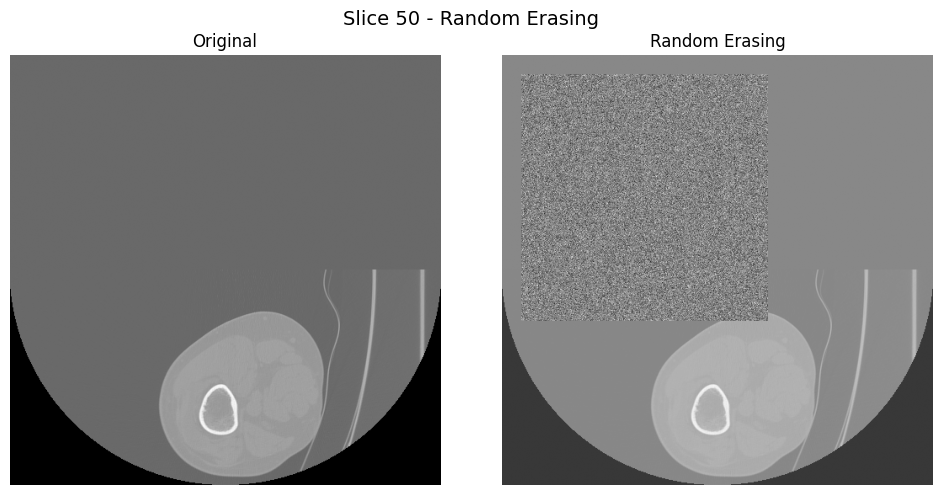

In [ ]:
img_path = r'/home/anuuu/Documents/Internship/Tasks/Perturbation/left_bilateral_knee_1_image.nii.gz'

# Apply random erasing
original_image, erased_image = add_random_erasing(img_path, erase_fraction=0.3, fill_mode='noise')

# Estimate noise (optional, may not apply conceptually here)
noise_volume, noise_std = estimate_noise(original_image, erased_image)
print(f"Erased region std (rough): {noise_std:.3f}")

# Histogram
plot_intensity_histogram(original_image, erased_image, title="Voxel Intensity Histogram (Random Erasing)")

# Visualize effect
visualize_single_slice(original_image, erased_image, slice_index=50, title_prefix="Random Erasing")


In [41]:
import nibabel as nib
import numpy as np

def add_gaussian_noise(image_path, mean=0, std=10):
    """
    Add Gaussian noise to a 3D image loaded from NIfTI.

    Parameters:
    - image_path: path to NIfTI file
    - mean: mean of Gaussian noise (usually 0)
    - std: standard deviation of noise (controls strength)

    Returns:
    - original_image: original image array
    - noisy_image: image with Gaussian noise added
    """
    img_nifti = nib.load(image_path)
    image = img_nifti.get_fdata()

    noise = np.random.normal(loc=mean, scale=std, size=image.shape)
    noisy_image = image + noise

    return image, noisy_image


Estimated noise std: 99.995


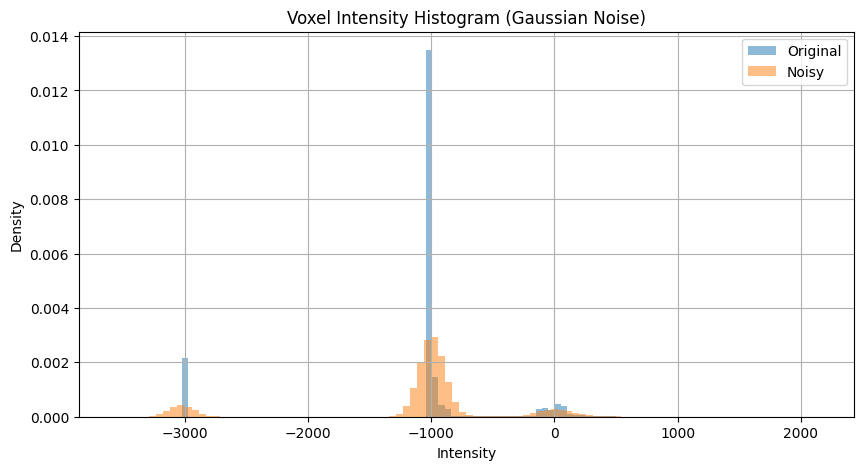

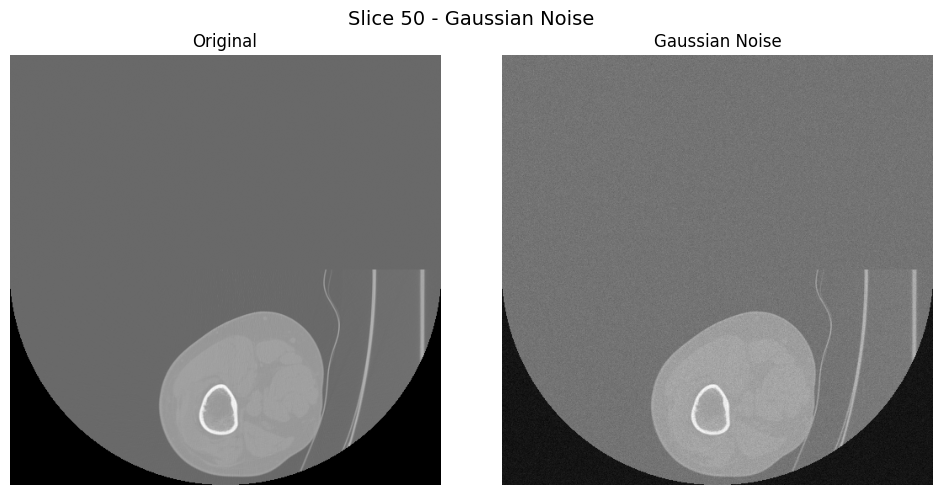

In [44]:
# Apply Gaussian noise
original_image, noisy_image = add_gaussian_noise(img_path, mean=0, std=100)

# Estimate actual noise
noise_volume, noise_std = estimate_noise(original_image, noisy_image)
print(f"Estimated noise std: {noise_std:.3f}")

# Plot histogram
plot_intensity_histogram(original_image, noisy_image, title="Voxel Intensity Histogram (Gaussian Noise)")

# Visualize one slice
visualize_single_slice(original_image, noisy_image, slice_index=50, title_prefix="Gaussian Noise")

In [45]:
import nibabel as nib
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion


In [ ]:
def adapt_mask_volume(mask_path, operation='dilate', target_increase=0.1, max_iterations=30):
    """
    Morphologically dilate or erode a binary mask to change volume by target percentage.

    Parameters:
    - mask_path: path to NIfTI mask file
    - operation: 'dilate' or 'erode'
    - target_increase: fractional change in volume (e.g., 0.1 for 10%)
    - max_iterations: max number of steps to try

    Returns:
    - original_mask: binary 3D array before adaptation
    - adapted_mask: binary 3D array after adaptation
    - voxel_counts: dict with volume stats
    """
    mask_nifti = nib.load(mask_path)
    mask = mask_nifti.get_fdata() > 0  # ensure binary

    original_volume = np.sum(mask)
    adapted = mask.copy()
    iterations = 0

    while iterations < max_iterations:
        if operation == 'dilate':
            temp = binary_dilation(adapted)
        elif operation == 'erode':
            temp = binary_erosion(adapted)
        else:
            raise ValueError("operation must be 'dilate' or 'erode'")

        new_volume = np.sum(temp)
        change = (new_volume - original_volume) / original_volume

        if (operation == 'dilate' and change >= target_increase) or \
           (operation == 'erode' and change <= -target_increase):
            break

        adapted = temp
        iterations += 1

    voxel_counts = {
        'original_voxels': int(original_volume),
        'adapted_voxels': int(np.sum(adapted)),
        'delta (%)': round(100 * (np.sum(adapted) - original_volume) / original_volume, 2),
        'iterations': iterations
    }

    return mask.astype(np.uint8), adapted.astype(np.uint8), voxel_counts


In [47]:
def visualize_mask_volume_adaptation(image, original_mask, adapted_mask, slice_index):
    """
    Display the original and adapted mask overlaid on the CT image.

    Parameters:
    - image: 3D CT image (NumPy array)
    - original_mask: original binary mask
    - adapted_mask: dilated or eroded mask
    - slice_index: axial slice index to visualize
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Mask Volume Adaptation - Slice {slice_index}", fontsize=14)

    # Original mask overlay
    axes[0].imshow(image[:, :, slice_index], cmap='gray')
    axes[0].imshow(original_mask[:, :, slice_index], alpha=0.5, cmap='Reds')
    axes[0].set_title("Original Mask")
    axes[0].axis('off')

    # Adapted mask overlay
    axes[1].imshow(image[:, :, slice_index], cmap='gray')
    axes[1].imshow(adapted_mask[:, :, slice_index], alpha=0.5, cmap='Blues')
    axes[1].set_title("Adapted Mask")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


Volume Change:
original: 1328018
adapted: 1658431
delta (%): 24.88
iterations: 4


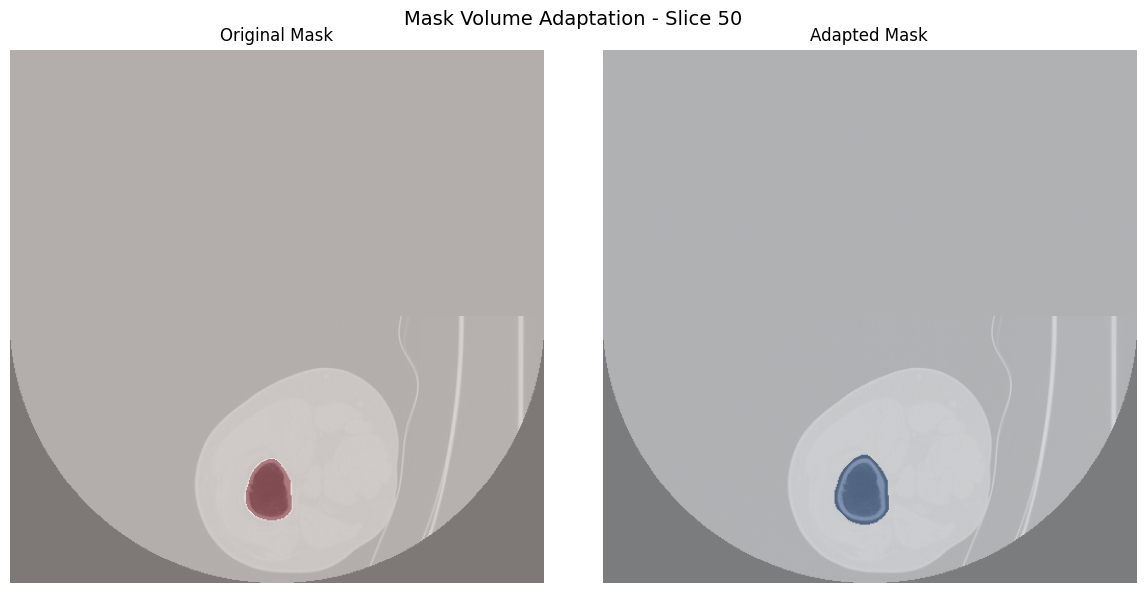

In [ ]:
# Set paths to your files
image_path = r'/home/anuuu/Documents/Internship/Tasks/Perturbation/left_bilateral_knee_1_image.nii.gz'
mask_path = r'/home/anuuu/Documents/Internship/Tasks/Perturbation/knee_label.nii.gz'

# Load image
image = nib.load(image_path).get_fdata()

# Run 10% dilation
original_mask, adapted_mask, stats = adapt_mask_volume(
    mask_path=mask_path,
    operation='dilate',       # or 'erode'
    target_increase=0.30      # 10% volume increase
)

# Print volume stats
print("Volume Change:")
for k, v in stats.items():
    print(f"{k}: {v}")

# Visualize on slice 50
visualize_mask_volume_adaptation(image, original_mask, adapted_mask, slice_index=50)


In [2]:
import numpy as np
import nibabel as nib
from skimage.segmentation import slic
from skimage.measure import regionprops
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt
import random


In [7]:
def perturb_roi_with_supervoxels(image_3d, roi_mask, n_segments=500, compactness=0.1, min_overlap=0.9):
    """
    Perturbs an ROI mask using 3D SLIC supervoxels.

    Parameters:
    - image_3d: 3D image (for intensity-based supervoxel generation)
    - roi_mask: 3D binary mask of ROI
    - n_segments: number of supervoxels
    - compactness: balances color proximity and space proximity
    - min_overlap: threshold to always keep supervoxels

    Returns:
    - perturbed_mask: new binary mask with randomized ROI
    """
    # Normalize intensity for better supervoxel quality
    image_norm = (image_3d - np.min(image_3d)) / (np.max(image_3d) - np.min(image_3d))

    labels = slic(
        image_norm,
        n_segments=n_segments,
        compactness=compactness,
        start_label=1,
        channel_axis=None  # For grayscale
    )

    perturbed_mask = np.zeros_like(roi_mask)

    for label_id in np.unique(labels):
        supervoxel = labels == label_id
        intersection = np.logical_and(supervoxel, roi_mask)
        overlap_ratio = intersection.sum() / supervoxel.sum()

        if overlap_ratio >= min_overlap:
            perturbed_mask[supervoxel] = 1
        elif overlap_ratio > 0:
            if np.random.rand() < overlap_ratio:
                perturbed_mask[supervoxel] = 1

    return perturbed_mask

In [8]:
def visualize_mask_overlay(image_3d, original_mask, perturbed_mask, slice_index):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(image_3d[:, :, slice_index], cmap='gray')
    axes[0].imshow(original_mask[:, :, slice_index], alpha=0.4, cmap='Reds')
    axes[0].set_title('Original ROI Mask')
    axes[0].axis('off')

    axes[1].imshow(image_3d[:, :, slice_index], cmap='gray')
    axes[1].imshow(perturbed_mask[:, :, slice_index], alpha=0.4, cmap='Blues')
    axes[1].set_title('Perturbed ROI Mask')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


In [9]:
def save_nifti(data, reference_nifti_path, output_path):
    ref_nifti = nib.load(reference_nifti_path)
    new_nifti = nib.Nifti1Image(data.astype(np.uint8), affine=ref_nifti.affine, header=ref_nifti.header)
    nib.save(new_nifti, output_path)
    print(f"✅ Saved perturbed mask to: {output_path}")

In [ ]:
image_path = r'/home/anuuu/Documents/Internship/Tasks/Perturbation/left_bilateral_knee_1_image.nii.gz'
mask_path = r'/home/anuuu/Documents/Internship/Tasks/Perturbation/knee_label.nii.gz'
output_mask_path = r'/home/anuuu/Documents/Internship/Tasks/Perturbation/left_bilateral_knee_1_mask_perturbed.nii.gz'

# Load data
image_nifti = nib.load(image_path)
mask_nifti = nib.load(mask_path)

image_data = image_nifti.get_fdata()
mask_data = mask_nifti.get_fdata().astype(np.uint8)

# Apply perturbation
perturbed_mask = perturb_roi_with_supervoxels(
    image_3d=image_data,
    roi_mask=mask_data,
    n_segments=800,
    compactness=0.2,
    min_overlap=0.85
)

# Visualize a slice (change index as needed)
visualize_mask_overlay(image_data, mask_data, perturbed_mask, slice_index=50)

# Save to disk
save_nifti(perturbed_mask, reference_nifti_path=image_path, output_path=output_mask_path)

KeyboardInterrupt: 